In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import sys
import folium
import statsmodels.formula.api as sm
from folium import plugins
from multiprocessing import Pool

In [2]:
raw=pd.read_csv("Border_Crossing_Entry_Data.csv", parse_dates=['Date']) #Importing the data from csv and parsing the date column as date type
print("Dimensions: ",raw.shape)
raw.head()

Dimensions:  (346733, 8)


,Port Name,State,Port Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,US-Mexico Border,2019-03-01,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,US-Canada Border,2019-03-01,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,US-Mexico Border,2019-03-01,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,US-Mexico Border,2019-03-01,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,US-Canada Border,2019-03-01,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


In [3]:
# Filtering the types of vehicles crossing the border
drop_list = ['Trucks','Trains','Personal Vehicles','Buses']
raw = raw[~raw.Measure.isin(drop_list)]

In [4]:
# Retaining data for the years from 1996 to 2018
raw=raw.loc[~(raw['Date'] >= '2018-12-31')]
raw.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
2367,Presidio,Texas,2403,US-Mexico Border,2018-12-01,Bus Passengers,238,POINT (-104.37167 29.56056)
2368,Anacortes,Washington,3010,US-Canada Border,2018-12-01,Personal Vehicle Passengers,5350,POINT (-122.61738999999999 48.49988)
2369,Brownsville,Texas,2301,US-Mexico Border,2018-12-01,Truck Containers Full,9871,POINT (-97.49722 25.90139)
2370,Maida,North Dakota,3416,US-Canada Border,2018-12-01,Truck Containers Empty,162,POINT (-98.36953 48.98568)
2371,Columbus,New Mexico,2406,US-Mexico Border,2018-12-01,Pedestrians,24168,POINT (-107.63944 31.827499999999997)


In [5]:
# Splitting the Year from Date variable and create a new column
raw['Year']=raw['Date'].astype(str).str.slice(start=0,stop=4)

In [6]:
df = raw.copy()

In [8]:
# Spliting data as per Borders
mex=raw[raw.Border=='US-Mexico Border']
can=raw[raw.Border=='US-Canada Border']

# Resetting the index
mex.reset_index(drop=True, inplace=True)
can.reset_index(drop=True, inplace=True)

# Define category variable to split data as per Commercial and Passenger traffic
categories=['Personal Vehicle Passengers', 'Bus Passengers', 'Pedestrians' ,'Train Passengers']
can.loc[:,'Category'] = np.where(can.loc[:,'Measure'].isin(categories),'Passengers','Commercial')
mex.loc[:,'Category'] = np.where(mex.loc[:,'Measure'].isin(categories),'Passengers','Commercial')

pd.options.mode.chained_assignment = None

Text(0.5, 0.98, 'US-Canada Border State wise Crossing')

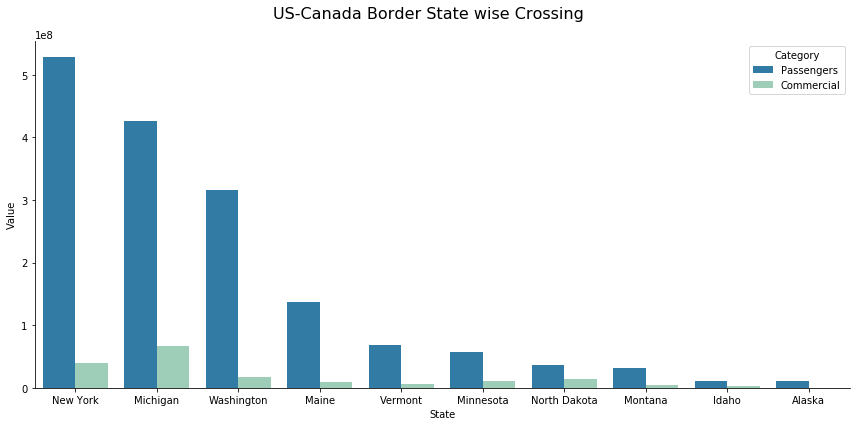

In [9]:
# 'US-Canada Border': State wise
can_summ=can.groupby(['State','Category'],as_index=False)['Value'].sum()
cx = sns.catplot("State","Value", data=can_summ.sort_values('Value',ascending=False),hue="Category",kind="bar",palette="YlGnBu_r",height=6,aspect=2,legend_out=False)
cx.fig.subplots_adjust(top=.9)
cx.fig.suptitle('US-Canada Border State wise Crossing', fontsize=16)

Text(0.5, 0.98, 'US-Mexico Border State wise Crossing')

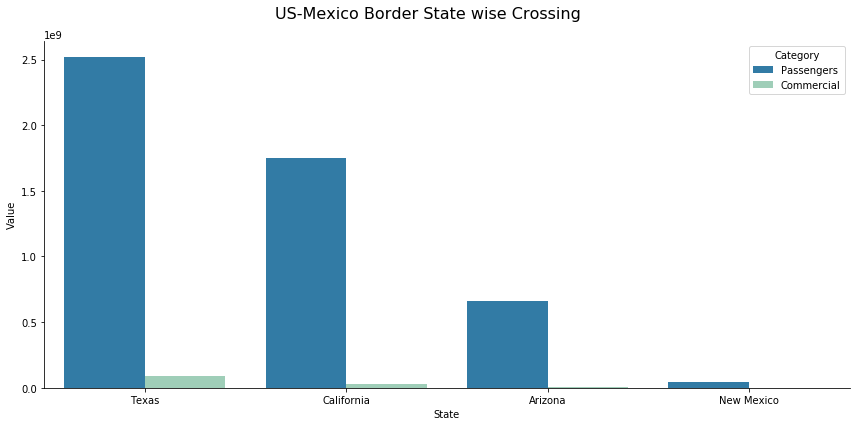

In [10]:
# 'US-Mexico Border': State wise
mex_summ=mex.groupby(['State','Category'],as_index=False)['Value'].sum()
mx = sns.catplot("State","Value", data=mex_summ.sort_values('Value',ascending=False),hue="Category",kind="bar",palette="YlGnBu_r",height=6,aspect=2,legend_out=False)
mx.fig.subplots_adjust(top=.9)
mx.fig.suptitle('US-Mexico Border State wise Crossing', fontsize=16)

Text(0.5, 1.0, 'US-Canada Border')

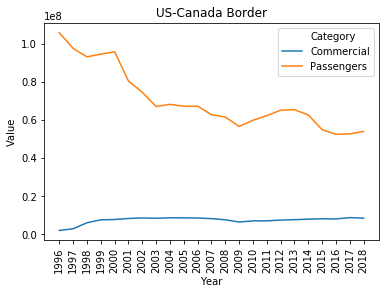

In [11]:
# Plotting time series analysis on yearwise passenger and commercial traffic fr US Canada border
can_summ=can.groupby(['Year','Category'],as_index=False)['Value'].sum()
ax = sns.lineplot(x="Year", y="Value", hue="Category", data=can_summ)
plt.xticks(rotation=90)
ax.set_title('US-Canada Border')

Text(0.5, 1.0, 'US-Mexico Border')

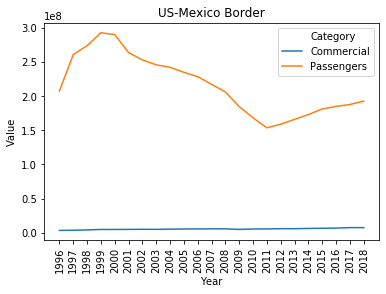

In [12]:
# Plotting time series analysis on yearwise passenger and commercial traffic fr US Canada border
mex_summ=mex.groupby(['Year','Category'],as_index=False)['Value'].sum()
ax = sns.lineplot(x="Year", y="Value", hue="Category", data=mex_summ)
plt.xticks(rotation=90)
ax.set_title('US-Mexico Border')

In [13]:
#Clean Up of Location Column to extract Latitude/Longitutes for each port of entry
df['Location'] = df['Location'].str.strip('POINT').str.strip(' (').str.strip(')') 
df['Location'] = df['Location'].str.replace(" ", ",")
df['Longitude']=df['Location'].str.split(',').str[0]
df['Latitude']=df['Location'].str.split(',').str[1]

In [14]:
#Sub-frame with all the ports for California along with Crossing Details
cmb = df[df['State'] == 'California'] 
calport = cmb.groupby(['Port Name', 'Latitude', 'Longitude']).agg({"Value" : "mean"}).sort_values(by = 'Value', ascending = False).reset_index()
calport['Value'] = calport['Value'].astype(int)
calport.head()

,Port Name,Latitude,Longitude,Value
0,San Ysidro,32.54306,-117.02666999999998,944803
1,Calexico,32.67889,-115.49806000000001,513609
2,San Ysidro,32.54,-117.03,371868
3,Otay Mesa,32.57333,-117.05333,216079
4,Calexico,32.66,-115.49999999999999,187638


In [15]:
#Plot a Border Map of California highlighting the Ports, with their size proportional to the number of Crossings
California=folium.Map([32.007, -114.1003],zoom_start=7)
#location=location[0:2000]
for lat,lon,val, nm in zip(calport['Latitude'],calport['Longitude'],calport['Value'], calport['Port Name']):
     folium.CircleMarker([lat, lon],
                            popup= nm + " Count: " +  str(val),
                            radius=val * 0.00005, 
                            color='black',
                            fill=True,
                            fill_opacity=0.5,
                            #fill_color=,
                           ).add_to(California)
#California.save('California.html')

California

In [16]:
#Sub-frame with all the ports for Texas along with Crossing Details
tmb = df[df['State'] == 'Texas']
texport = tmb.groupby(['Port Name', 'Latitude', 'Longitude']).agg({"Value" : "mean"}).sort_values(by = 'Value', ascending = False).reset_index()
texport['Value'] = texport['Value'].astype(int)

In [17]:
#Plot a Border Map of Texas highlighting the Ports, with their size proportional to the number of Crossings
Texas=folium.Map([32.007, -106.1003],zoom_start=5)
#location=location[0:2000]
for lat,lon,val, nm in zip(texport['Latitude'],texport['Longitude'],texport['Value'], texport['Port Name']):
     folium.CircleMarker([lat, lon],
                            popup= nm + " Count: " +str(val),
                            radius=val * 0.0001,
                            color='black',
                            fill=True,
                            fill_opacity=0.5,
                            #fill_color=,
                           ).add_to(Texas)
#Texas.save('Texas.html')

Texas

In [18]:
#Sub-frame with all the ports for New York along with Crossing Details
ny = df[df['State'] == 'New York']
nyp = ny.groupby(['Port Name', 'Latitude', 'Longitude']).agg({"Value" : "mean"}).sort_values(by = 'Value', ascending = False).reset_index()
nyp['Value'] = nyp['Value'].astype(int)

In [19]:
#Plot a Border Map of New York highlighting the Ports, with their size proportional to the number of Crossings
NewYork=folium.Map([42.007, -79.1003],zoom_start=6)
#location=location[0:2000]
for lat,lon,val, nm in zip(nyp['Latitude'],nyp['Longitude'],nyp['Value'], nyp['Port Name']):
     folium.CircleMarker([lat, lon],
                            popup= nm + " Count: " + str(val),
                            radius=val * 0.0003,
                            color='black',
                            fill=True,
                            fill_opacity=0.5,
                            #fill_color=,
                           ).add_to(NewYork)
#NewYork.save('NewYork.html')

NewYork

In [20]:
df = raw.copy()

In [21]:
#Create a new Data Frame from the original set with Human Crossings
df = pd.DataFrame(df[df["Measure"].isin(["Bus Passengers","Pedestians","Personal Vehicle Passengers","Train Passengers"])])

In [22]:
df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,Year
2367,Presidio,Texas,2403,US-Mexico Border,2018-12-01,Bus Passengers,238,POINT (-104.37167 29.56056),2018
2368,Anacortes,Washington,3010,US-Canada Border,2018-12-01,Personal Vehicle Passengers,5350,POINT (-122.61738999999999 48.49988),2018
2376,Lukeville,Arizona,2602,US-Mexico Border,2018-12-01,Personal Vehicle Passengers,56937,POINT (-112.81500000000001 31.8825),2018
2379,Highgate Springs-Alburg,Vermont,212,US-Canada Border,2018-12-01,Personal Vehicle Passengers,63798,POINT (-73.10583 44.979440000000004),2018
2392,Dalton Cache,Alaska,3106,US-Canada Border,2018-12-01,Bus Passengers,14,POINT (-135.40995 59.10606000000001),2018


In [23]:
#Creating dummy variables for variable State and Measure
dummies_1 = pd.get_dummies(df['State']).rename(columns=lambda x: str(x))
dummies_2 = pd.get_dummies(df['Measure']).rename(columns=lambda x: str(x))
df = pd.concat([df, dummies_1, dummies_2], axis=1)
df.drop(columns='Location',inplace=True)

In [24]:
#Since we want value to be easier to read, we modify the column order
cols = list(df.columns)
cols = [cols[6]]+cols[:6]+cols[7:]
df = df[cols]
df.head(3)

,Value,Port Name,State,Port Code,Border,Date,Measure,Year,Alaska,Arizona,...,Montana,New Mexico,New York,North Dakota,Texas,Vermont,Washington,Bus Passengers,Personal Vehicle Passengers,Train Passengers
2367,238,Presidio,Texas,2403,US-Mexico Border,2018-12-01,Bus Passengers,2018,0,0,...,0,0,0,0,1,0,0,1,0,0
2368,5350,Anacortes,Washington,3010,US-Canada Border,2018-12-01,Personal Vehicle Passengers,2018,0,0,...,0,0,0,0,0,0,1,0,1,0
2376,56937,Lukeville,Arizona,2602,US-Mexico Border,2018-12-01,Personal Vehicle Passengers,2018,0,1,...,0,0,0,0,0,0,0,0,1,0


In [25]:
#We adjust the name of columns to help us with our linear regression model
df.columns = ['Value', 'Port', 'State', 'PortC', 'Border', 'Date', 'Measure','Year',
       'Alaska', 'Arizona', 'California', 'Idaho', 'Maine', 'Michigan',
       'Minnesota', 'Montana', 'New_Mexico', 'New_York', 'North_Dakota',
       'Texas', 'Vermont', 'Washington', 'Bus',
       'Personal_Vehicle', 'Train']

In [32]:
def measureTime(fun,arg):
    '''Function to measure time for a utility being called in it. It returns the total execution time in seconds.'''
    startTime = time.time()
    fun(arg)
    endTime = time.time()
    return endTime-startTime

def runOLS(tr):
    '''Function to instantiate an OLS model on the given data (tr) and return the model metric as AIC'''
    result = sm.ols(formula=fun,data=tr).fit()
    return result.rsquared

fun = 'Value ~ Bus + Train + Personal_Vehicle + California + New_York + Texas + Year'

In [27]:
#Strategic Sampling of the given dataset to verify computation times on different dataset sizes
df1 = df.loc[(df['Date'] >= '2012-12-31')] #Rows: 20137
df2 = df.loc[(df['Date'] >= '2007-12-31')] #Rows: 40135
df3 = df.loc[(df['Date'] >= '2003-12-31')] #Rows: 56209
df4 = df.loc[(df['Date'] >= '1999-12-31')] #Rows: 71230
df5 = df.loc[(df['Date'] >= '1995-12-31')] #Rows: 86062

In [33]:
#Evaluate the time taken for regression to run on different dataset sizes
samples = [df1,df2,df3,df4,df5]
nGrid=[20137,40135,56209,71230,86062]
times = []
rsq= []
startTime_Linear = time.time()
for i in samples:
    t=measureTime(runOLS,i)
    #print(t)
    r=runOLS(i)
    #print(rsq)
    times.append(t)
    rsq.append(r)
endTime_Linear = time.time()

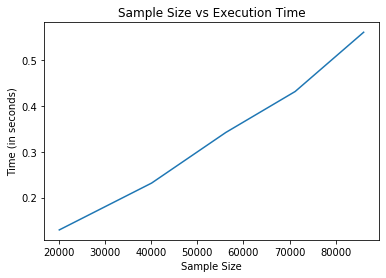

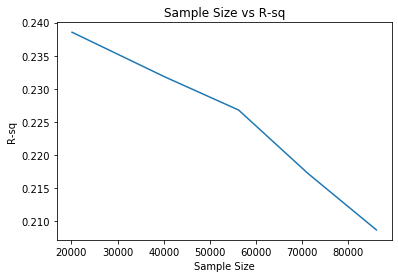

In [35]:
#Plot evaluating Runtimes against the dataset size
fig = plt.figure()
plt.plot(nGrid,times, label = "Time consuming")
plt.xlabel('Sample Size')
plt.ylabel("Time (in seconds)")
plt.title('Sample Size vs Execution Time')
plt.show()

#Plot Evaluating the AIC against the dataset size passed to the Regression Model
fig2 = plt.figure()
plt.plot(nGrid,rsq)
plt.xlabel('Sample Size')
plt.ylabel("R-sq")
plt.title('Sample Size vs R-sq')
plt.show()

In [30]:
#Implementing Parallel processing to simultaneously execute the regression models on different dataset sizes 
#while varying the number of processes made available

from multiprocessing import Pool
time_parallel = list()
processors = list()
startTime_Total = time.time()
if __name__ == '__main__':
    for i in range(1,5):
        p = Pool(processes=i)
        startTime=time.time()
        p.map(runOLS, [df1,df2,df3,df4,df5])
        endTime=time.time()
        p.close()
        time_parallel.append(endTime-startTime)
        processors.append(i)
        print("Using ",i," processors it took", endTime-startTime, " seconds")
endTime_Total = time.time()
print(endTime_Total-startTime_Total)

Using  1  processors it took 1.857043981552124  seconds
Using  2  processors it took 1.2796058654785156  seconds
Using  3  processors it took 1.1114318370819092  seconds
Using  4  processors it took 1.0326569080352783  seconds
5.342852830886841


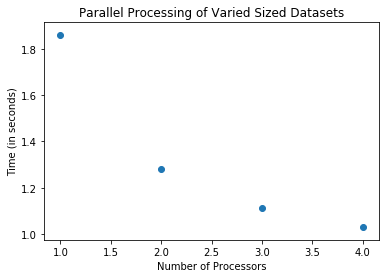

In [31]:
#Plot the time taken to execute Regression models in parallel against the number of processes made available
fig = plt.figure()
plt.scatter(processors,time_parallel)
plt.xlabel('Number of Processors')
plt.ylabel("Time (in seconds)")
plt.title('Parallel Processing of Varied Sized Datasets')
plt.show()